## Import libraries

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader
from transformers import AdamW, get_scheduler
from tqdm.auto import tqdm
import numpy as np
import math
from sklearn.metrics import accuracy_score
import time  
from torch.utils.data import DataLoader
import wandb
import matplotlib.pyplot as plt
from torch import softmax
import pandas as pd

## Set device for fine-tuning

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda:0


## We will be using the SST2 (Stanford Sentiment Treebank) dataset from the 🤗 Datasets library:
Link: https://huggingface.co/datasets/stanfordnlp/sst2

In [3]:
# SST2
sst2 = load_dataset("stanfordnlp/sst2")

In [4]:
# check no. of samples in train, test, valid splits
sst2

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

#### Look at an example:

In [5]:
sst2['train'][1]

{'idx': 1, 'sentence': 'contains no wit , only labored gags ', 'label': 0}

## Preprocessing with tokenizer

I have chosen the 'distilbert-base-uncased' pretrained model as tokenizer for this assignment.

In [6]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

C:\Users\ASUS\anaconda3\envs\nlp\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Ensure both truncation and padding during tokenization

In [7]:
def tokenize_function(example):
    return tokenizer(example["sentence"], padding=True, truncation=True, max_length=128)

# Tokenize the entire dataset
tokenized_datasets = sst2.map(tokenize_function, batched=True)

In [8]:
# Remove unnecessary columns
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx"])

#### Created a batch of examples using DataCollatorWithPadding for applying dynamic padding to each sentence

In [9]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Defining training arguments

In [10]:
training_args = TrainingArguments(
    output_dir='distilbert_finetuned_model',  # Save the model',
    learning_rate=3e-5,  # Slightly higher learning rate
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,  # Consider experimenting with 3-5 epochs
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=500,  # Log after every 500 steps
    lr_scheduler_type='linear',  # Include a scheduler for better control over training dynamics
    warmup_steps=500,  # Gradually increase LR to avoid large initial updates
)

C:\Users\ASUS\anaconda3\envs\nlp\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Using Weights & Biases for keeping track of training and validation loss/accuracy
https://docs.wandb.ai/quickstart/ 

### Defining CustomTrainer for customized training and validation loops

In [11]:
# Initialize W&B project
wandb.init(project="distilbert-sst2-classifier")  # Set your W&B project

class CustomTrainer:
    def __init__(self, model, tokenizer, train_dataset, eval_dataset, data_collator,args):
        self.model = model
        self.tokenizer = tokenizer
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.data_collator = data_collator
        self.args = args

        # DataLoader for train and evaluation
        self.train_dataloader = DataLoader(train_dataset, batch_size=args.per_device_train_batch_size, collate_fn=data_collator)
        self.eval_dataloader = DataLoader(eval_dataset, batch_size=args.per_device_eval_batch_size, collate_fn=data_collator)

        # Optimizer
        self.optimizer = AdamW(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

        # Learning rate scheduler
        num_training_steps = len(self.train_dataloader) * self.args.num_train_epochs
        self.lr_scheduler = get_scheduler(
            name="linear", optimizer=self.optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=num_training_steps
        )

        # Move model to device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        # Lists to store training history
        self.train_losses = []
        self.train_accuracies = []
        self.eval_losses = []
        self.eval_accuracies = []
        self.steps = []
        
    def train(self):
        self.model.train()
        total_steps = len(self.train_dataloader) * self.args.num_train_epochs
        progress_bar = tqdm(range(total_steps), desc="Training")

        # Track total training time
        training_start_time = time.time()

        for epoch in range(int(self.args.num_train_epochs)):
            epoch_train_loss = 0
            correct_preds = 0
            total_preds = 0

            # Track epoch-level training start time
            epoch_start_time = time.time()

            for step, batch in enumerate(self.train_dataloader):
                batch = {k: v.to(self.device) for k, v in batch.items()}  # Move batch to device

                outputs = self.model(**batch)
                loss = outputs.loss
                loss.backward()

                # Optimizer and scheduler step
                self.optimizer.step()
                self.lr_scheduler.step()
                self.optimizer.zero_grad()

                # Calculate train loss and accuracy
                epoch_train_loss += loss.item()
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1)
                correct_preds += (preds == batch["labels"]).sum().item()
                total_preds += preds.size(0)

                progress_bar.update(1)

                # Print and log training loss/accuracy and validation metrics every 500 steps
                if step % 500 == 0 and step > 0:
                    avg_step_loss = epoch_train_loss / (step + 1)
                    step_accuracy = correct_preds / total_preds
                    print(f"Step [{step}/{len(self.train_dataloader)}]")
                    print(f"Train Loss: {avg_step_loss:.4f}, Train Accuracy: {step_accuracy:.4f}")
                    
                    # Evaluate the model on validation data
                    avg_eval_loss, eval_accuracy, eval_time = self.evaluate()
                    print(f"Validation Loss: {avg_eval_loss:.4f}, Validation Accuracy: {eval_accuracy:.4f}")

                    # Log to W&B
                    wandb.log({
                        "train_loss_step": avg_step_loss,
                        "train_accuracy_step": step_accuracy,
                        "valid_loss_step": avg_eval_loss,
                        "valid_accuracy_step": eval_accuracy,
                        "step": step + epoch * len(self.train_dataloader)
                    })

                    # Store epoch metrics for plotting
                    self.train_losses.append(avg_step_loss)
                    self.train_accuracies.append(step_accuracy)
                    self.steps.append(step/len(self.train_dataloader))

                    # Store eval metrics for plotting
                    self.eval_losses.append(avg_eval_loss)
                    self.eval_accuracies.append(eval_accuracy)

            avg_train_loss = epoch_train_loss / len(self.train_dataloader)
            train_accuracy = correct_preds / total_preds
  
            # Track time per epoch
            epoch_end_time = time.time()
            epoch_time = epoch_end_time - epoch_start_time
            print(f"Epoch {epoch + 1} took {epoch_time:.2f} seconds")
            print(f"Epoch [{epoch + 1}] - Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

            # Log train loss, accuracy, and epoch time to W&B
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "epoch_time": epoch_time
            })

            # Evaluate at the end of each epoch
            avg_eval_loss, eval_accuracy, eval_time = self.evaluate()
            print(f"Epoch [{epoch + 1}] - Validation Loss: {avg_eval_loss:.4f}, Validation Accuracy: {eval_accuracy:.4f}")

            wandb.log({
                "epoch": epoch + 1,
                "valid_loss": avg_eval_loss,
                "valid_accuracy": eval_accuracy,
                "eval_time": eval_time
            })

        # Track total training time
        training_end_time = time.time()
        total_training_time = training_end_time - training_start_time
        print(f"Total Training Time: {total_training_time:.2f} seconds")

        # Log total training time to W&B
        wandb.log({
            "total_training_time": total_training_time
        })
        return self.train_accuracies, self.train_losses, self.eval_accuracies, self.eval_losses, self.steps   #use for plotting loss/accuracy curves

    def evaluate(self):
        self.model.eval()
        all_preds = []
        all_labels = []
        total_eval_loss = 0

        # Track inference start time
        inference_start_time = time.time()

        for batch in self.eval_dataloader:
            batch = {k: v.to(self.device) for k, v in batch.items()}

            with torch.no_grad():
                outputs = self.model(**batch)

            loss = outputs.loss
            total_eval_loss += loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

        avg_eval_loss = total_eval_loss / len(self.eval_dataloader)
        eval_accuracy = accuracy_score(all_labels, all_preds)

        # Track inference end time
        inference_end_time = time.time()
        inference_time = inference_end_time - inference_start_time

        print(f"Inference Time: {inference_time:.2f} seconds")
        # Log inference time to W&B
        wandb.log({
            "inference_time": inference_time
        })

        return avg_eval_loss, eval_accuracy, inference_time

    def save_model(self, output_dir):
        self.model.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: samad037 (samad037-university-of-minnesota). Use `wandb login --relogin` to force relogin


## Mapping of the expected ids to their labels with id2label and label2id.

In [12]:
labels = ['NEGATIVE', 'POSITIVE']
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in id2label.items()}

print('id2label:', id2label)
print('label2id:', label2id)

id2label: {0: 'NEGATIVE', 1: 'POSITIVE'}
label2id: {'NEGATIVE': 0, 'POSITIVE': 1}


## Initializing the pretrained "distilbert-base-uncased" model

In [13]:
# MODEL
checkpoint = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=len(labels), id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model  # check model layers

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## Initialize CustomTrainer

In [15]:
# `training_args` contains arguments like learning_rate, batch size, epochs, etc.
custom_trainer = CustomTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    args=training_args
)

C:\Users\ASUS\anaconda3\envs\nlp\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Start the training and track time

In [16]:
start_time = time.time()

train_accuracies, train_losses, eval_accuracies, eval_losses, steps = custom_trainer.train()  # Train the model

end_time = time.time()
total_time = end_time - start_time

Training:   0%|          | 0/4210 [00:00<?, ?it/s]

Step [500/4210]
Train Loss: 0.4185, Train Accuracy: 0.7834
Inference Time: 1.40 seconds
Validation Loss: 0.3720, Validation Accuracy: 0.8509
Step [1000/4210]
Train Loss: 0.3320, Train Accuracy: 0.8425
Inference Time: 1.38 seconds
Validation Loss: 0.2627, Validation Accuracy: 0.8933
Step [1500/4210]
Train Loss: 0.2931, Train Accuracy: 0.8663
Inference Time: 1.38 seconds
Validation Loss: 0.2506, Validation Accuracy: 0.9037
Step [2000/4210]
Train Loss: 0.2661, Train Accuracy: 0.8822
Inference Time: 1.39 seconds
Validation Loss: 0.2577, Validation Accuracy: 0.8899
Step [2500/4210]
Train Loss: 0.2472, Train Accuracy: 0.8937
Inference Time: 1.39 seconds
Validation Loss: 0.2552, Validation Accuracy: 0.8979
Step [3000/4210]
Train Loss: 0.2317, Train Accuracy: 0.9018
Inference Time: 1.38 seconds
Validation Loss: 0.2290, Validation Accuracy: 0.9037
Step [3500/4210]
Train Loss: 0.2204, Train Accuracy: 0.9077
Inference Time: 1.39 seconds
Validation Loss: 0.2261, Validation Accuracy: 0.9014
Step [4

In [17]:
custom_trainer.save_model("distilbert_finetuned_model")  # Save the model

## Creating loss and accuracy plots

In [18]:
import matplotlib.pyplot as plt

def plot_training_metrics(train_losses, train_accuracies, eval_losses, eval_accuracies, steps):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(steps, train_losses, 'b-', label='Train Loss')
    plt.plot(steps, eval_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('% 1 Epoch completed')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(steps, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(steps, eval_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('% 1 Epoch completed')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


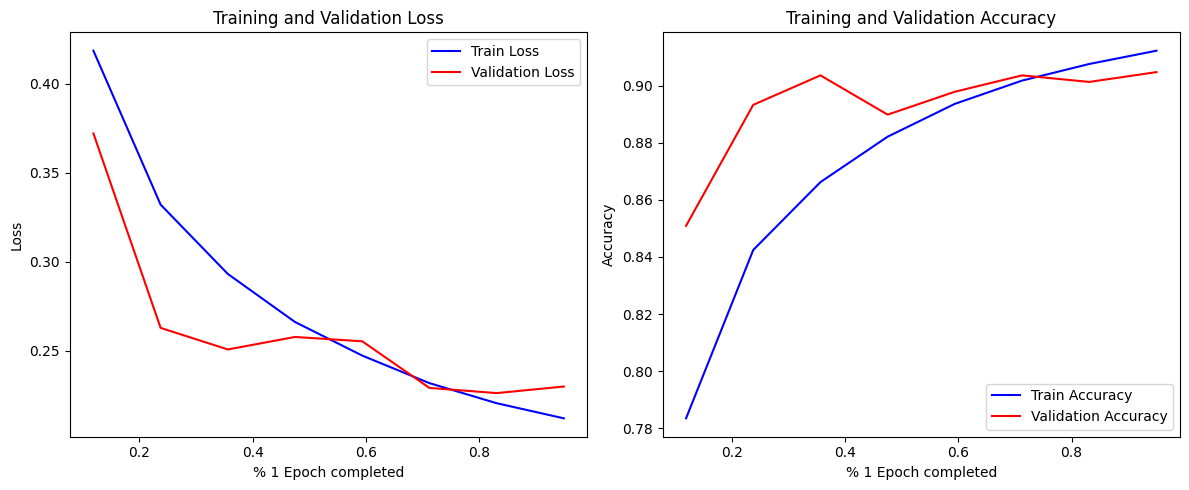

In [19]:
plot_training_metrics(train_losses, train_accuracies, eval_losses, eval_accuracies,steps)

## Validation set evaluation - evaluation metric used is accuracy_score from sklearn

In [20]:
avg_eval_loss, eval_accuracy, inference_time = custom_trainer.evaluate()
print(f"Average eval accuracy: {eval_accuracy}")
print(f"Average eval loss: {avg_eval_loss}")

Inference Time: 1.41 seconds
Average eval accuracy: 0.9048165137614679
Average eval loss: 0.232360632175749


## Inference on a test sample

In [21]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification

### Instantiating a pipeline for sentiment analysis with our finetuned model

In [22]:
def check_inference(text):
    classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=device)
    print("CLassifier Output :")
    print(classifier(text))
    print("\n")

    # Tokenize the text and return PyTorch tensors:
    inputs = tokenizer(text, return_tensors='pt').to(device)

    # Pass inputs to the model and return the logits:
    with torch.no_grad():
        logits = model(**inputs).logits

    pos_idx = model.config.label2id['POSITIVE']
    pos_score = logits[0, pos_idx].item()
    
    neg_idx = model.config.label2id['NEGATIVE']
    neg_score = logits[0, neg_idx].item()
    
    print("POSITIVE Score: {:.4f}".format(pos_score))
    print("NEGATIVE Score: {:.4f}".format(neg_score))

    predicted_class_id = logits.argmax().item() # is the first output or second output bigger? get ID of bigger output
    print("Predicted class: "+model.config.id2label[predicted_class_id]) # translate ID to human-readable label

In [23]:
text1 = sst2["test"][148]["sentence"]
print("Input text : "+text1+"\n")
check_inference(text1)

Input text : good for a few unintentional laughs , `` extreme ops '' was obviously made for the `` xxx '' crowd , people who enjoy mindless action without the benefit of decent acting , writing , and direction .

CLassifier Output :
[{'label': 'NEGATIVE', 'score': 0.7965080738067627}]


POSITIVE Score: -0.6362
NEGATIVE Score: 0.7284
Predicted class: NEGATIVE


In [24]:
text2 = "This was a masterpiece. Not completely faithful to the books, but enthralling from beginning to end. Might be my favorite of the three."
print("Input text : "+text2+"\n")
check_inference(text2)

Input text : This was a masterpiece. Not completely faithful to the books, but enthralling from beginning to end. Might be my favorite of the three.

CLassifier Output :
[{'label': 'POSITIVE', 'score': 0.9809688329696655}]


POSITIVE Score: 2.3078
NEGATIVE Score: -1.6347
Predicted class: POSITIVE


## Getting 50 wrong predictions on Valid set 

In [25]:
def evaluate_and_capture_incorrect_predictions(model, args, eval_dataset, tokenizer, device, batch_size=16, max_incorrect=50):
    model.eval()
    all_inputs = []
    all_ground_truths = []
    all_predictions = []
    all_confidences = []

    eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size)
    eval_dataloader = DataLoader(eval_dataset, batch_size=args.per_device_eval_batch_size, collate_fn=data_collator)
    
    for batch in eval_dataloader:
        # Ensure that batch is a dictionary
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            probs = softmax(logits, dim=-1)

        # Collect inputs and predictions
        all_inputs.extend(tokenizer.batch_decode(input_ids, skip_special_tokens=True))
        all_ground_truths.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        all_confidences.extend(probs.cpu().numpy())

    # Find incorrectly predicted samples
    incorrect_indices = [i for i, (pred, true) in enumerate(zip(all_predictions, all_ground_truths)) if pred != true]
    incorrect_samples = np.random.choice(incorrect_indices, size=min(max_incorrect, len(incorrect_indices)), replace=False)

    # Prepare data for exporting
    error_samples = []
    for idx in incorrect_samples:
        error_samples.append({
            "Input Text": all_inputs[idx],
            "Ground Truth": all_ground_truths[idx],
            "Predicted Label": all_predictions[idx],
            "Confidence score of predicted label": all_confidences[idx][all_predictions[idx]].item()
        })

    # Create a DataFrame
    df = pd.DataFrame(error_samples)
    
    return df

In [26]:
# get wrong predictions into a dataframe and export it to csv
df_incorrect = evaluate_and_capture_incorrect_predictions(model,training_args,tokenized_datasets["validation"], tokenizer, device)

In [27]:
df_incorrect.to_csv('incorrect_predictions.csv', index=False)

## Load the manual analysis excel file

In [28]:
file_path = 'Analysis_of_Incorrect_predictions.xlsx'
sheet_number = "Sheet1"  # Sheet number starts from 0

# Read the Excel file
df_analysis = pd.read_excel(file_path, sheet_name=sheet_number)

# Display the first few rows of the data
# print(df_analysis.head(2))

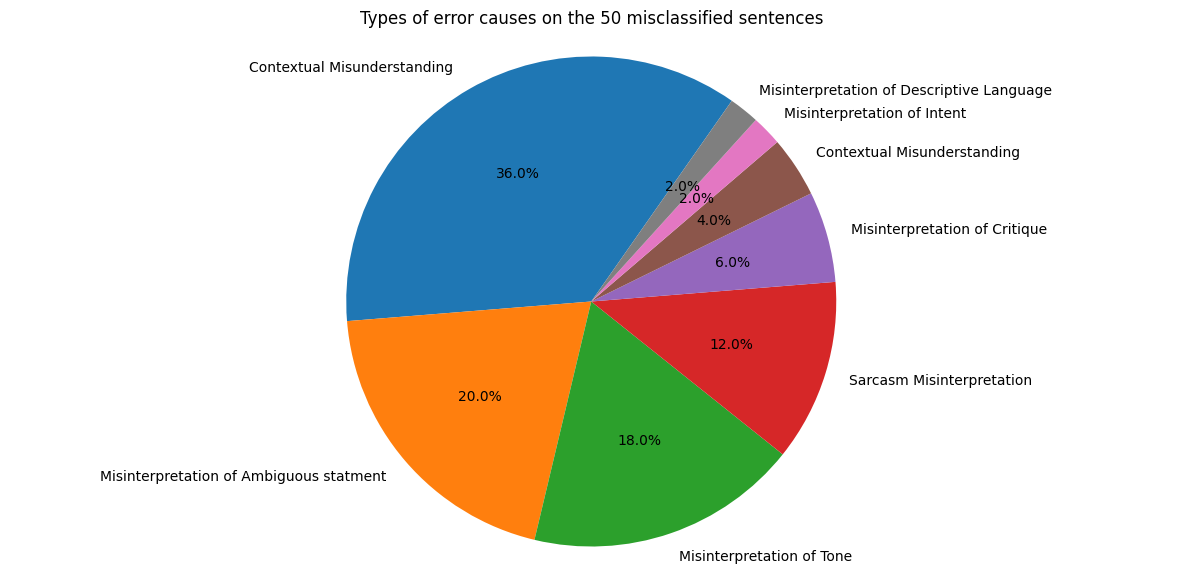

In [29]:
value_counts = df_analysis['Cause Term'].value_counts()


plt.figure(figsize=(15, 7))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=55)
plt.title('Types of error causes on the 50 misclassified sentences')
plt.axis('equal')  
plt.show()

### Frequency Distribution of Error Types: Calculate the frequency of each error type (e.g., false positive, false negative).

In [30]:
from tabulate import tabulate
error_type_counts = df_analysis['Error Types'].value_counts()
# print(error_type_counts)

# Convert the Series to a DataFrame
error_type_counts_df = error_type_counts.reset_index()
error_type_counts_df.columns = ['Error Type', 'Frequency']

# Print the table using tabulate
table = tabulate(error_type_counts_df, headers='keys', tablefmt='fancy_grid', showindex=False)
print("Frequency table for Error Types:")
print(table)

Frequency table for Error Types:
╒════════════════╤═════════════╕
│ Error Type     │   Frequency │
╞════════════════╪═════════════╡
│ False Positive │          30 │
├────────────────┼─────────────┤
│ False Negative │          20 │
╘════════════════╧═════════════╛


## Frequency table for Cause Term

In [31]:
cause_term_counts = df_analysis['Cause Term'].value_counts().reset_index()
cause_term_counts.columns = ['Cause Term', 'Frequency']

# Print tables using tabulate
cause_term_table = tabulate(cause_term_counts, headers='keys', tablefmt='fancy_grid', showindex=False)

print("\nFrequency Table for Cause Terms:")
print(cause_term_table)


Frequency Table for Cause Terms:
╒═══════════════════════════════════════════╤═════════════╕
│ Cause Term                                │   Frequency │
╞═══════════════════════════════════════════╪═════════════╡
│ Contextual Misunderstanding               │          18 │
├───────────────────────────────────────────┼─────────────┤
│ Misinterpretation of Ambiguous statment   │          10 │
├───────────────────────────────────────────┼─────────────┤
│ Misinterpretation of Tone                 │           9 │
├───────────────────────────────────────────┼─────────────┤
│ Sarcasm Misinterpretation                 │           6 │
├───────────────────────────────────────────┼─────────────┤
│ Misinterpretation of Critique             │           3 │
├───────────────────────────────────────────┼─────────────┤
│ Contextual Misunderstanding               │           2 │
├───────────────────────────────────────────┼─────────────┤
│ Misinterpretation of Intent               │           1 │
├─────

## Frequency table for Potential Solutions

In [32]:
potential_fixes_counts = df_analysis['Potential solutions'].value_counts().reset_index()
potential_fixes_counts.columns = ['Potential solutions', 'Frequency']

potential_fixes_table = tabulate(potential_fixes_counts, headers='keys', tablefmt='fancy_grid', showindex=False)

print("\nFrequency Table for Potential Fixes:")
print(potential_fixes_table)


Frequency Table for Potential Fixes:
╒══════════════════════════════════════════════════════════════════════════════════════════╤═════════════╕
│ Potential solutions                                                                      │   Frequency │
╞══════════════════════════════════════════════════════════════════════════════════════════╪═════════════╡
│ Aspect-Based Sentiment Analysis                                                          │          15 │
├──────────────────────────────────────────────────────────────────────────────────────────┼─────────────┤
│ Post-processing to Detect Complex Emotions                                               │          11 │
├──────────────────────────────────────────────────────────────────────────────────────────┼─────────────┤
│ Training on Mixed Sentiment Structures:                                                  │           9 │
├──────────────────────────────────────────────────────────────────────────────────────────┼─────────────┤

## Step 7: Error Visualization with t-SNE plot

In [33]:
# Collect true labels and predictions
import torch.nn.functional as F

# Function to compute prediction probabilities
def compute_probabilities(logits):
    # Apply softmax to get probabilities for each class
    probs = F.softmax(logits, dim=-1)
    return probs

In [54]:
# Collect true labels, predictions, and prediction probabilities
all_labels = []
all_preds = []
all_probs = []

for batch in custom_trainer.eval_dataloader:
    batch = {k: v.to(custom_trainer.args.device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = custom_trainer.model(**batch)
    
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)  # Get predicted classes
    probs = compute_probabilities(logits)  # Get probabilities for all classes
    
    # Store the probability of the predicted class for each sample
    predicted_probs = probs.gather(1, predictions.unsqueeze(-1)).squeeze(-1)
    
    all_preds.extend(predictions.cpu().numpy())
    all_labels.extend(batch["labels"].cpu().numpy())
    all_probs.extend(predicted_probs.cpu().numpy())  # Store the probabilities

# Convert lists to numpy arrays, take upto 500 samples
all_labels = np.array(all_labels)[:500]
all_preds = np.array(all_preds)[:500]
all_probs = np.array(all_probs)[:500]

In [55]:
# Find incorrect predictions
incorrect_mask = all_labels != all_preds
correct_mask = all_labels == all_preds
negative_mask = []
positive_mask = []

for mask, labels in zip(correct_mask, all_labels):
  if mask == True:
    if labels == 0:
      negative_mask.append(True)
      positive_mask.append(False)
    elif labels == 1:
      positive_mask.append(True)
      negative_mask.append(False)
  else:
      positive_mask.append(False)
      negative_mask.append(False)

## Extract embeddings for all samples in the evaluation set

In [56]:
model.eval()
all_embeddings = []

for batch in custom_trainer.eval_dataloader:
    batch = {k: v.to(custom_trainer.args.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = custom_trainer.model.distilbert(**batch)
    
    # Extract embeddings from the last hidden state
    hidden_states = outputs.last_hidden_state[:, 0, :]  # Take the embedding for the [CLS] token
    all_embeddings.extend(hidden_states.cpu().numpy())

# Convert embeddings to numpy array - taking 500 samples
all_embeddings = np.array(all_embeddings)[:500]

## Get all correct and incorrect prediction scores

In [57]:
incorrect_prob = all_probs[incorrect_mask]
negative_prob = all_probs[negative_mask]
positive_prob = all_probs[positive_mask]

## Apply t-SNE to get embeddings in 2D space

In [58]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the embeddings to 2D space
tsne = TSNE(n_components=2, random_state=58)
embeddings_2d = tsne.fit_transform(all_embeddings)[:500]

In [59]:
embeddings_2d.shape

(500, 2)

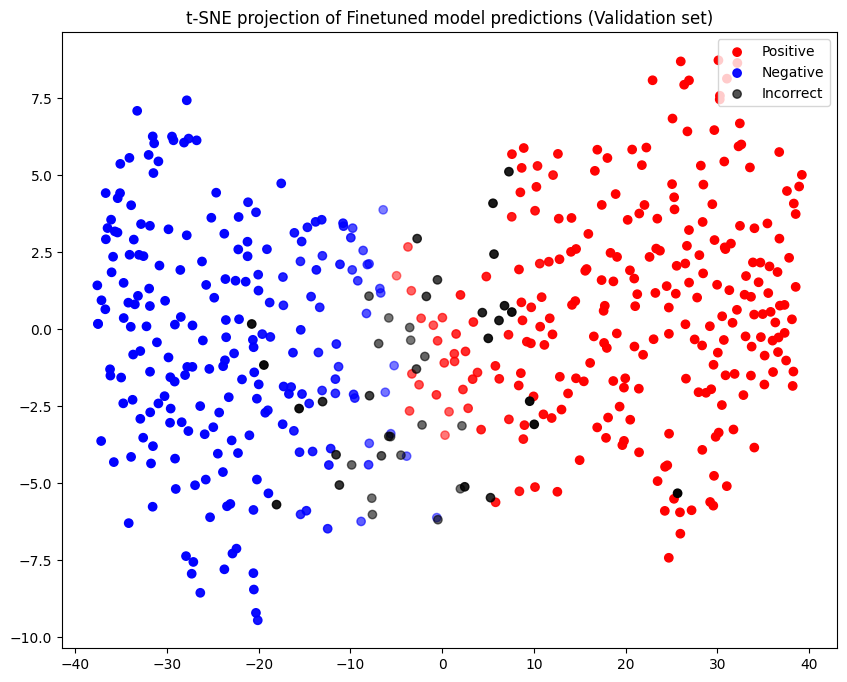

In [60]:
# Define the correct and incorrect points
negative_points = embeddings_2d[negative_mask]
positive_points = embeddings_2d[positive_mask]
incorrect_points = embeddings_2d[incorrect_mask]

# Create a scatter plot
plt.figure(figsize=(10, 8))

# Plot correct positive predictions
plt.scatter(positive_points[:, 0], positive_points[:, 1], c='red', label='Positive', alpha=positive_prob)

# Plot correct negative predictions
plt.scatter(negative_points[:, 0], negative_points[:, 1], c='blue', label='Negative', alpha=negative_prob)

# Plot incorrect predictions
plt.scatter(incorrect_points[:, 0], incorrect_points[:, 1], c='black', label='Incorrect', alpha=incorrect_prob)

plt.legend(loc="upper right")
plt.title("t-SNE projection of Finetuned model predictions (Validation set)")
plt.show()